In [16]:
import numpy as np

np.random.seed(42)

## Constants
Below are constants defined for the code

In [31]:
from datetime import datetime

print(datetime.now())

2025-12-05 13:11:31.742191


In [17]:
NUM_QUBITS = 4
RABI_FREQUENCY = 50 * (10 ** 3)
OMEGA_M = 2.75 * (10 ** 6)
MU = 14 * (10 ** 3) # Hardcoded to 10 Khz
NUM_BLOCKS = 4
NUM_PHI_VALUES = 100
PHI_RANGE = np.linspace(-np.pi, np.pi, NUM_PHI_VALUES)

## Circuit for Quantum Sensing

### Define Hamiltonian 

$$
H_s \;=\; \sum_{i<j} J_{ij}\,\sigma_i^{\theta}\sigma_j^{\theta}
$$

$$
J_{ij} \;=\; \Omega_i \Omega_j \eta_{i}\,\eta_{j}\, 
\frac{\mu}{\mu^{2}-\omega_m^{2}}
$$

$$
\sigma^{\theta}_i = \cos(\theta)\sigma^x_i - \sin(\theta)\sigma^y_i
$$
$$
\sigma^{\theta}_i\sigma^{\theta}_j = \cos^2(\theta)\sigma^x_i\sigma^x_j + \sin^2(\theta)\sigma^y_i\sigma^y_j - \sin(\theta)\cos(\theta)(\sigma^x_i\sigma^y_j + \sigma^y_i\sigma^x_j)
$$

For now assuming
- $\eta_{i} = 0.1 * (-1)^i$
- $\Omega_{i,j} = 50 Khz$
- $\mu = 10 KHz\ to\ 20 KHz$
- $\omega_{m} = 2.75 Mhz$, We are only considering zig zag mode, hence we have no summation
- $\theta$ = trainable parameter


In [18]:
def J(i, j):
    n_i = 0.1 * (-1) ** i
    n_j = 0.1 * (-1) ** j

    return RABI_FREQUENCY * RABI_FREQUENCY * n_i * n_j * (MU) / (MU ** 2 - OMEGA_M ** 2)


print(J(0, 0))
print(J(0, 1))
print(J(1, 0))

-0.046282191247535145
0.046282191247535145
0.046282191247535145


In [19]:
qubit_pairs = [(i, j) for i in range(NUM_QUBITS) for j in range(i + 1, NUM_QUBITS)]
print(qubit_pairs)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [20]:
from quspin.basis import spin_basis_1d
from quspin.operators import hamiltonian

basis = spin_basis_1d(L=NUM_QUBITS, pauli=True)

def hamiltonian_matrix(theta):
    xx_list = [[np.square(np.cos(theta)) * J(i,j), i, j] for i,j in qubit_pairs]
    yy_list = [[np.square(np.sin(theta)) * J(i,j), i, j] for i,j in qubit_pairs]
    xy_list = yx_list = [[(-1) * np.sin(theta) * np.cos(theta) * J(i,j), i, j] for i,j in qubit_pairs]

    static_terms = [
        ['xx', xx_list],
        ['yy', yy_list],
        ['xy', xy_list],
        ['yx', yx_list],
    ]
    
    # print(static_terms)
    return hamiltonian(static_terms, [], basis=basis).tocsc()

hamiltonian_matrix(np.pi / 2)

Hermiticity check passed!
Symmetry checks passed!


<Compressed Sparse Column sparse matrix of dtype 'complex128'
	with 96 stored elements and shape (16, 16)>

### Quantum circuit

In [21]:
from functools import reduce

# Pauli matrices and identity
I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

def rx(theta):
    """Single-qubit Rx rotation."""
    return np.cos(theta/2) * I - 1j * np.sin(theta/2) * X

def ry(theta):
    """Single-qubit Ry rotation."""
    return np.cos(theta/2) * I - 1j * np.sin(theta/2) * Y

def rz(theta):
    return np.cos(theta/2) * I - 1j * np.sin(theta/2) * Z
    
def kron_n(mat, n):
    """n-fold Kronecker (tensor) product."""
    return reduce(np.kron, [mat] * n)

def rx_all_qubits(theta):
    """Rx rotation on all qubits."""
    return kron_n(rx(theta), NUM_QUBITS)

def ry_all_qubits(theta):
    """Ry rotation on all qubits."""
    return kron_n(ry(theta), NUM_QUBITS)

def rz_all_qubits(theta):
    return kron_n(rz(theta), NUM_QUBITS)

In [22]:
from scipy.sparse.linalg import expm_multiply

rx_all_pi_2 = rx_all_qubits(np.pi/2)
ry_all_pi_2 = ry_all_qubits(np.pi/2)

def run_circuit(phi, encoder_parameters, decoder_parameters):
    ''' Runs quantum circuit and returns state vector'''
    if encoder_parameters.shape != (NUM_BLOCKS, 2):
        raise ValueError(f"encoder_parameters must have shape {(NUM_BLOCKS, 2)}, got {encoder_parameters.shape}")

    if decoder_parameters.shape != (NUM_BLOCKS, 2):
        raise ValueError(f"decoder_parameters must have shape {(NUM_BLOCKS, 2)}, got {decoder_parameters.shape}")

    # initializing state vector to zero
    state_vector = np.zeros(basis.Ns, dtype=np.complex128)
    state_vector[0] = 1.0
    
    state_vector = ry_all_pi_2 @ state_vector
    
    # Encoder layer
    for single_rotation, theta in encoder_parameters:
        state_vector = rx_all_qubits(single_rotation) @ state_vector
        hamiltonian = hamiltonian_matrix(theta)
        state_vector = expm_multiply(-1j * hamiltonian, state_vector)
   
    # Sensing layer
    state_vector = rz_all_qubits(phi) @ state_vector 
       
    # Decoder layer    
    for single_rotation, theta in decoder_parameters:
        state_vector = rx_all_qubits(single_rotation) @ state_vector
        hamiltonian = hamiltonian_matrix(theta)
        state_vector = expm_multiply(-1j * hamiltonian, state_vector)

    state_vector = rx_all_pi_2 @ state_vector
    
    return state_vector

encoder_parameters_random = np.random.uniform(size = (NUM_BLOCKS, 2))
decoder_parameters_random = np.random.uniform(size = (NUM_BLOCKS, 2))

run_circuit(0.1, encoder_parameters_random, decoder_parameters_random)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


array([-0.16682298-0.03646728j, -0.19760744+0.01129265j,
       -0.19760744+0.01129265j, -0.23535692+0.02400268j,
       -0.19760744+0.01129265j, -0.23983576+0.08740555j,
       -0.23535692+0.02400268j, -0.28493183+0.06389615j,
       -0.19760744+0.01129265j, -0.23535692+0.02400268j,
       -0.23983576+0.08740555j, -0.28493183+0.06389615j,
       -0.23535692+0.02400268j, -0.28493183+0.06389615j,
       -0.28493183+0.06389615j, -0.338579  +0.06500972j])

# Cost Calculations

The cost function to optimize is 

$C(\theta, \nu, a) = \int d\phi MSE(\phi) P_{\partial\phi}(\phi)$

where 

- $MSE(\phi) = \Sigma_m [\phi - \phi_{est}(m)]^2 p_{\theta, \nu}(m | \phi)$
- $\phi_{est} = a*m$, "a" is a trainable parameter and "m" is the measured value
- $ p_{\theta, \nu}(m | \phi) $ is probability of measuring state m given $\theta$ and $\nu$
- $P_{\partial\phi}(\phi)$ = ??
- "m" is sum of all spins and can range from `-NUM_QUBITS` ( all spin up) to `+NUM_QUBITS` (all spin up)


In [23]:

from scipy.integrate import simpson 

def state_to_magnetization(state: int):
    binary_representation = bin(state)
    hamming_weight = binary_representation.count('1')

    # When all spin down, hamming weight = N => m = -N
    # When all spin up,   hamming weight = 0 => m = N 
    return NUM_QUBITS - 2 * hamming_weight


def prior_wrapped_gaussian(phi, delta=0.3, k_max=5):
    ''' 
    Phi is periodic, so we make the gaussian distribution periodic by shifting and summing it.
    :param delta is the variance of distribution
    :kmax is the number of shifts of gaussian distribution added. 
    '''
    return sum(
        np.exp(-((phi + 2 * np.pi * k) ** 2) / (2 * delta ** 2))
        for k in range(-k_max, k_max + 1)
    ) / (np.sqrt(2 * np.pi) * delta)


def mean_square_error(phi, encoder_parameters, decoder_parameters, a):
    mse = 0.0
    state_vector = run_circuit(phi, encoder_parameters, decoder_parameters)
    probabilities = np.abs(state_vector) ** 2 
    for state, prob in enumerate(probabilities):
        magnetization = state_to_magnetization(state)
        phi_est = a * magnetization
        mse += ((phi_est - phi) ** 2) * prob

    return mse


def cost_function(encoder_parameters, decoder_parameters, a):
    cost_for_phi = []
    for phi in PHI_RANGE:
        cost = mean_square_error(phi, encoder_parameters, decoder_parameters, a) * prior_wrapped_gaussian(phi)
        cost_for_phi.append(cost)

    return simpson(cost_for_phi, PHI_RANGE) 

In [24]:
# Checking if cost is working or not
cost_function(encoder_parameters_random, decoder_parameters_random, 0.1)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


np.float64(0.14707526204252935)

# Optimization loop

In [25]:
def flatten_params(encoder_parameters, decoder_parameters, a):
    return np.concatenate([encoder_parameters.ravel(), decoder_parameters.ravel(), np.array([a])])

def unflatten_params(x):
    i = 0
    encoder_parameters = x[i : i + 2 * NUM_BLOCKS].reshape(NUM_BLOCKS, 2)
    i += 2 * NUM_BLOCKS
    decoder_parameters = x[i : i + 2 * NUM_BLOCKS].reshape(NUM_BLOCKS, 2)
    i += 2 * NUM_BLOCKS
    a = x[i]
    return encoder_parameters, decoder_parameters, a

# Mark parameters as trainable
encoder_parameters_random = np.random.uniform(-np.pi, np.pi, (NUM_BLOCKS, 2))
decoder_parameters_random = np.random.uniform(-np.pi, np.pi, (NUM_BLOCKS, 2))
a_random = np.random.uniform(-np.pi, np.pi)

flattened_random = flatten_params(encoder_parameters_random, decoder_parameters_random, a_random)
encoder_parameters_unflattened, decoder_parameters_unflattened, a_unflatened  = unflatten_params(flattened_random)

print(encoder_parameters_random == encoder_parameters_unflattened)
print(decoder_parameters_random == decoder_parameters_unflattened)
print(a_random == a_unflatened)

[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
True


In [26]:
from scipy.optimize import minimize

cost_history = []
def cost_wrapper(flattened):
    encoder_parameters, decoder_parameters, a = unflatten_params(flattened)
    cost = cost_function(encoder_parameters, decoder_parameters, a)
    cost_history.append(cost)
    return cost 

options = {
    'maxiter': 100, 
    'disp': True
}

optimized_parameters = minimize(cost_wrapper, flattened_random,  method='Nelder-Mead', options=options)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


/var/folders/m8/ss4zlk6s50n051yw97x7xm900000gn/T/ipykernel_15175/71898833.py:15: RuntimeWarning: Maximum number of iterations has been exceeded.
  optimized_parameters = minimize(cost_wrapper, flattened_random,  method='Nelder-Mead', options=options)


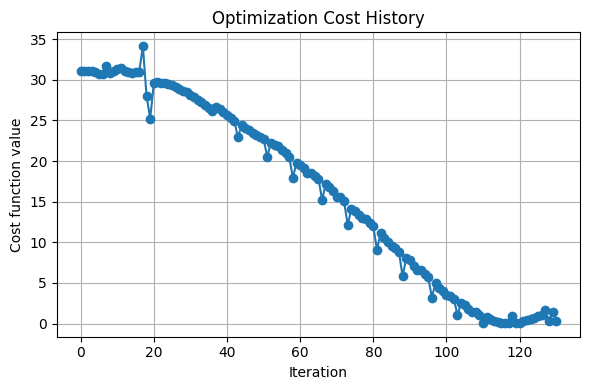

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(cost_history, marker='o', linestyle='-', color='C0')
plt.xlabel('Iteration')
plt.ylabel('Cost function value')
plt.title('Optimization Cost History')
plt.grid(True)
plt.tight_layout()
plt.show()

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


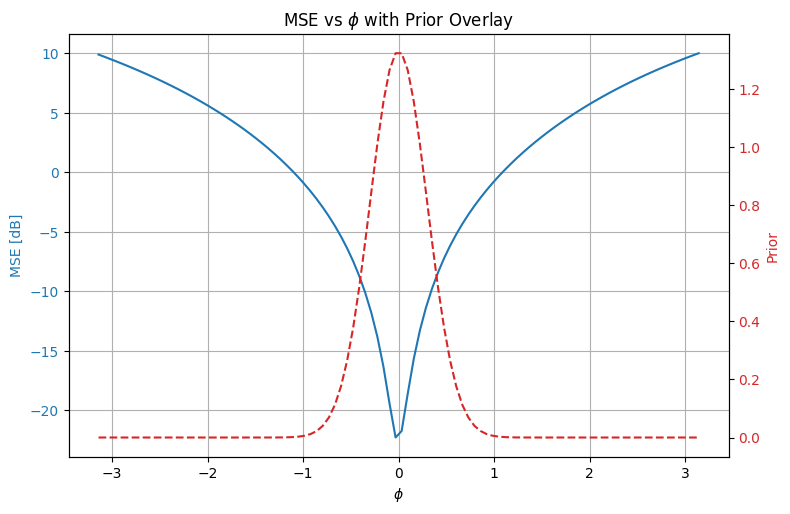

In [28]:
# plot MSE vs PHI
optimized_encoder_parameters, optimized_decoder_parameters, optimized_a = unflatten_params(optimized_parameters.x)

optimized_mse = lambda phi: mean_square_error(phi, optimized_encoder_parameters, optimized_decoder_parameters, optimized_a)
mse_values = [optimized_mse(phi) for phi in PHI_RANGE]
mse_db = 10* np.log10(mse_values)

prior_vals = np.array([prior_wrapped_gaussian(phi) for phi in PHI_RANGE])

# Plotting with twin axes
fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel(r"$\phi$")
ax1.set_ylabel("MSE [dB]", color=color1)
ax1.plot(PHI_RANGE, mse_db, color=color1, label="MSE (dB)")
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)

# Twin axis for prior
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel("Prior", color=color2)
ax2.plot(PHI_RANGE, prior_vals, color=color2, linestyle='--', label="Prior")
ax2.tick_params(axis='y', labelcolor=color2)

# Legends
fig.tight_layout()
plt.title("MSE vs $\phi$ with Prior Overlay")
plt.show()

In [29]:
optimized_parameters.x

array([-1.05478755,  0.16994395, -0.5294877 , -1.3966069 ,  0.78845893,
       -2.92791763, -1.28369909, -0.8150059 , -0.31364655,  1.81982176,
       -1.93837284,  0.07872594,  0.60216554, -2.91494168,  0.85146642,
       -2.31433009,  0.04300941])